In [12]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy, skew, kurtosis

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
### Load Dataset

X_raw = pd.read_csv("data/ECGData.csv", header=None).values
y_raw = pd.read_csv("data/ECGDataLabel.csv", header=None)[0]

label_map = {'ARR': 0, 'CHF': 1, 'NSR': 2}
y = y_raw.map(label_map).values

In [14]:
### ECG Segmentation

FS = 128
SEGMENT_SEC = 8
SEG_LEN = FS * SEGMENT_SEC

In [15]:
### Signal Segmentation

def segment_signal(signal, seg_len):
    n_seg = len(signal) // seg_len
    return np.array([
        signal[i * seg_len:(i + 1) * seg_len]
        for i in range(n_seg)
    ])

In [16]:
### Wavelet Feature Extraction

def extract_wavelet_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    energies = np.array([np.sum(c**2) for c in coeffs])
    total_energy = np.sum(energies)

    features = []
    for c, e in zip(coeffs, energies):
        c = np.asarray(c)
        features.extend([
            np.mean(c),
            np.std(c),
            skew(c),
            kurtosis(c),
            entropy(np.abs(c) + 1e-8),
            e / (total_energy + 1e-8)
        ])
    return features

In [17]:
### Record-Level Train–Test Split

record_idx = np.arange(len(X_raw))

train_idx, test_idx = train_test_split(
    record_idx,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [18]:
### Build Feature Matrix

X_train, y_train = [], []
X_test, y_test = [], []

for i in train_idx:
    segments = segment_signal(X_raw[i], SEG_LEN)
    for seg in segments:
        X_train.append(extract_wavelet_features(seg))
        y_train.append(y[i])

for i in test_idx:
    segments = segment_signal(X_raw[i], SEG_LEN)
    for seg in segments:
        X_test.append(extract_wavelet_features(seg))
        y_test.append(y[i])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
### Feature Scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
### Cost-Sensitive SVM + Hyperparameter Tuning

param_grid = {
    'C': [1, 10, 50],
    'gamma': ['scale', 0.01, 0.001]
}

svm = SVC(
    kernel='rbf',
    class_weight='balanced'
)

grid = GridSearchCV(
    svm,
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

In [21]:
### Evaluation

y_pred = best_model.predict(X_test)

print("Best Parameters:", grid.best_params_)
print()
print(classification_report(
    y_test,
    y_pred,
    target_names=['ARR', 'CHF', 'NSR']
))

Best Parameters: {'C': 1, 'gamma': 'scale'}

              precision    recall  f1-score   support

         ARR       0.92      0.89      0.90      1280
         CHF       0.76      0.78      0.77       384
         NSR       0.89      0.96      0.93       448

    accuracy                           0.88      2112
   macro avg       0.86      0.88      0.87      2112
weighted avg       0.88      0.88      0.88      2112



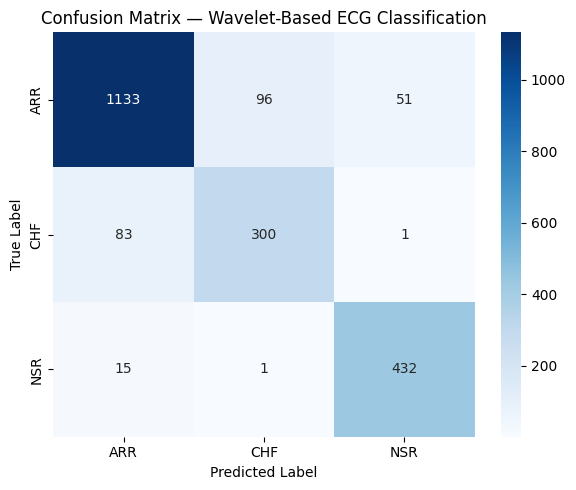

In [22]:
### Visualization

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['ARR', 'CHF', 'NSR'],
    yticklabels=['ARR', 'CHF', 'NSR']
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Wavelet-Based ECG Classification")
plt.tight_layout()
plt.show()